# Plotting earth with satellite imagery

For a more true to life rendering of the earth we are using NASA's Blue Marble Next Generation dataset (more info: https://visibleearth.nasa.gov/collection/1484/blue-marble and https://neo.gsfc.nasa.gov/view.php?datasetId=BlueMarbleNG)

There are 12 monthly images from 2004

The accessvis libary grabs all the imagery at full resolution and converts to cubemap textures. These textures can then be blended to create an image for any given day of the year.

We can also use the `astropy` library to calculate the sun's position and earth's rotation at a given time of day for more accurate lighting.

As a final example we create a sample animation blending the monthly images together to create a smooth transition through the year


In [1]:
import sys
import accessvis
import lavavu
import numpy as np
import math
import datetime
import os

For this example we recommend increasing the default model resolution/quality, feel free to adjust up or down depending on available resources where you are running this notebook 

In [2]:
accessvis.resolution_selection(default=1)

Low-res 2K - fast for testing
Mid-res 4K - good enough for full earth views
High res 8K - better if showing close up at country scale
Ultra-high 16K - max detail but requires a fast GPU with high memory


Dropdown(description='Detail:', index=1, options=(('Low-res 2K', 1), ('Mid-res 4K', 2), ('High-res 8K', 3), ('…

# Create earth visualisation in 3D

This time we pass a datetime object which controls which monthly satellite data image to use

When *blendtex* is enabled (default=True), the two month images either side of the chosen date are blended to produce a smooth transition interpolating the data for the days between the monthly image snapshots

When *sunlight* is enabled (default=False), the sun position is determined by the passed time and date, otherwise a dynamic sun light is placed directly behind the viewer so the model will always be front-illuminated regardless of how it is rotated, this is useful for interacting with the visualisation to be able to see details clearly but is obviously not a realistic lighting model.

First let's plot Australia on the 1st of January...

In [3]:
dt = datetime.datetime(2024, 1, 1, 12, 0, 0)
lv = accessvis.plot_earth(waves=True, when=dt, blendtex=True, vertical_exaggeration=15, sunlight=True)

/home/okaluza/ACCESS-NRI/visualisations/src/accessvis/data



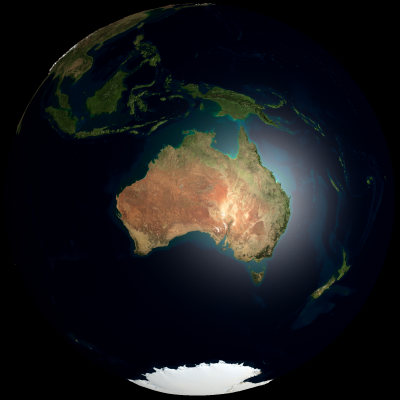

In [4]:
#Restore default view
lv.reset()

#Zoom out
lv.translation(0.0, 0.0, -17)

#Australia centred view
lv.rotation([-145, -42, 160])

#Show the output
lv.display((400,400))

Then zoom in to show a more detailed view


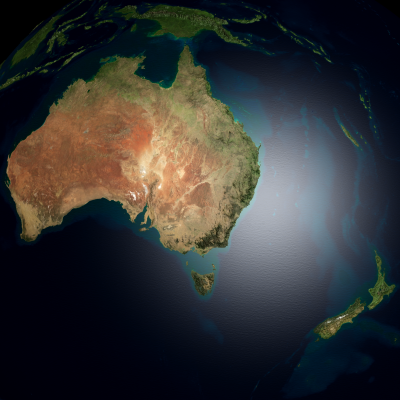

In [5]:
lv.translation(0.486, -0.75, -12.684)
lv.rotation(-137.839, -22.053, 155.435)

lv.display((400,400))

### Changing the date
The update_earth_datetime() function can be used to modify the date and time in an active visualisation.

Setting the date to August 1st, if we compare with the above image, notice the greener coastal regions and snow on the high country in SE Australia and NZ, you can also see the sun light appears further north and is not as directly overhead as it was in January


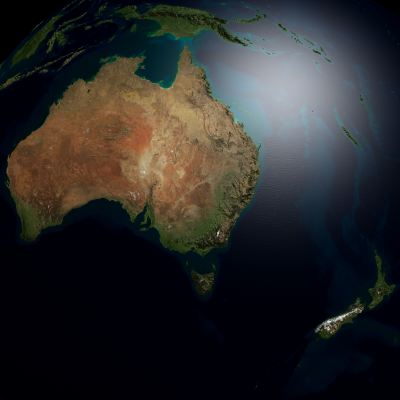

In [6]:
#Change date
dt = datetime.datetime(2024, 8, 1, 12, 0, 0)
accessvis.update_earth_datetime(lv, when=dt, sunlight=True)
lv.display((400,400))

### More on lighting adjustments

The function used to get the sun position is accessvis.sun_light()
It simply returns a 3D coordinate for the sun's position in our model coord system (based on Mm, millions of meters by default), which can then be passed to the "lightpos" parameter in the visualisation.
When called with no parameters it returns the dynamic light mode which follows the camera rather than a correctly positioned sun light.

In [7]:
SP = accessvis.sun_light()
SP

array([ 52632.03112289,  52632.03112289, 131580.07780723])

Verify the sun is at the correct distance in our coord system by calculating the vector length

Should be around 149.46 million km == 149460 million metres

In [8]:
np.linalg.norm(SP)

151174.0

If we want to get the current sun position, we can pass now=True, this defaults to the current time in the local timezone. Note 4th component set to 1 in returned data which indicates to the renderer that the light should remain at a fixed position in space, without this the light is switched to following the camera.

Other parameters are:
- time: provide a datetime object
- hour & minute: provide just the hour and/or minute instead
- local: use the local timezone
- tz: specify the timezone to use
- xyz: when not using time to position sun, use this xyz coord relative to the camera viewpoint

In [9]:
SP = accessvis.sun_light(now=True)
SP

[141615.1383464664, -15533.064105156747, 45211.25481318913, 1]

To apply this to the model, you can use the set_properties function of the viewer

2024-10-08 17:58:15.803258



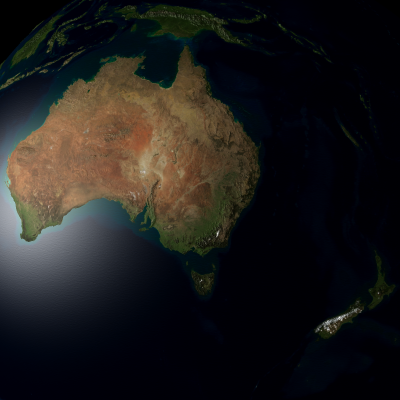

In [10]:
lv.set_properties(lightpos=accessvis.sun_light(now=True))
print(datetime.datetime.now())
lv.display((400,400))

### Get sun position at specific hour


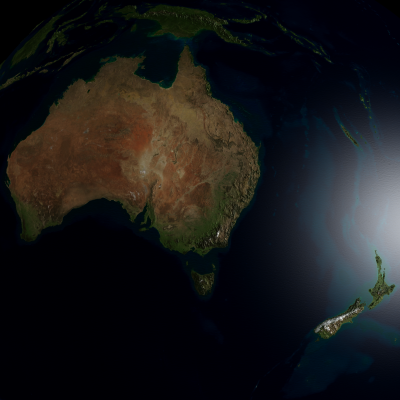

In [11]:
lp = accessvis.sun_light(hour=8)
lv.set_properties(lightpos=lp)
lv.display((400,400))

### Restore floating sun position (sun stays behind camera)

More useful for an interactive view


In [ ]:
lv.set_properties(lightpos=accessvis.sun_light())

In [ ]:
lv.window((600,600))

---

# Animation

Load seasonal textures and smoothly transition between them

In [ ]:
#Shading/colour/lighting settings
lv.brightness_contrast_saturation(0.5, 0.525, 0.45)

#Setup lighting
lv.set_properties(diffuse=0.4, ambient=0.65, specular=0.4, shininess=0.045, light=[1,1,0.98,1])

In [ ]:
#Northern hemisphere view for snow
lv.translation(0.0, 0.0, -16.75)
lv.rotation(40.775, -38.462, -21.42)

In [ ]:
from tqdm.notebook import tqdm
rot = 0
rinc = 0.02
with lv.video(filename='seasons.mp4', quality=3, resolution=(1440,1440), width=1440//2, height=1080//2, params="autoplay") as v:    
    step = 4 #2
    for d in tqdm(range(0,366,step), desc='Day'):
        dt = datetime.datetime.strptime(f'04 {str(d+1).zfill(3)} 12:00', '%y %j %H:%M')
        dt = dt.replace(tzinfo=datetime.timezone.utc)
        accessvis.update_earth_datetime(lv, when=dt, sunlight=True)
        lv["title"] = '+' + dt.strftime("%d/%m/%Y")
        lv.rotate('y', rinc) #Rotate about axis too
        lv.render()

    #Final frames
    for f in range(30):
        lv.rotate('y', rinc)
        lv.render()
